# Ecommerce Customer Churn

Like most e-commerce companies, this company faces a persistent retention challenge: a proportion of customers gradually disengage and stop purchasing (“churn”). Using the available data, the goal is to detect which customers are at risk of churning, so that the company can intervene proactively (e.g. giving out promos) to preserve customer relationships and revenue.

## Business Problem

Customer acquisition is costly and uncertain, while the timing of new-customer inflows is hard to predict. When existing customers churn, marketing must work harder (and spend more) to replace the dropping revenue. Although not universally true in every case, in most e-commerce settings the expected cost to retain an existing customer is lower than the fully loaded cost of acquiring a comparable new customer. The business therefore requires a scalable, reliable way to estimate churn risk at the individual level and proactively intervene to stabilize revenue.

## Goals 

1. Predict, at the customer level, the probability of churn
2. Understand important key drivers of churning

## Evaluation Metrics

We define a supervised classification task with target labels: 
* **churn** : 1
* **not churn** : 0

Confusion-matrix terms map to business outcomes as follows:
* True Positive (TP) = churners correctly identified (can be saved via intervention)
* False Positive (FP) = non-churners incorrectly flagged (unnecessary incentive risk)
* False Negative (FN) = churners missed (lost revenue and higher future acquisition burden)
* True Negative (TN) = non-churners correctly ignored (no spend).

Because missing a true churner (FN) typically carries higher economic cost than sending a cautious offer to a non-churner (FP), the evaluation will emphasize recall on the churn class (i.e., minimizing FNs), while still controlling FP. Accordingly, the primary model-selection metric is the F2 score, which weights recall more heavily than precision. But we will also report Recall and ROC AUC to provide a complete view of detection performance and model discrimination.

## Data Understanding and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/Users/winonathea/Downloads/E-commerce Customer Churn/data_ecommerce_customer_churn.csv')
df

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3939,6.0,NaN,4,Mobile,3,Married,10,1,0.0,124.37,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


#### There are 11 columns and 3941 rows in the dataset.

#### Below is the description of each column

* **Tenure** : Tenure of a customer in the company
* **WarehouseToHome** : Distance between the warehouse to the customer's home
* **Number of Device Registered** : Total number of device is registered on a particular customer
* **PreferedOrderCat** : Preferred Order Category of a customer **in the last month**
* **SatisfactionScore** : Satisfactory score of a customer on service
* **MaritalStatus** : Marital status of a customer
* **NumberofAddress** : Total number of address on a particular customer
* **Complaint** : Any complaint has been raised **in the last month**
* **DaySinceLastOrder** : Day since last order by customer
* **Cashback Amount** : Average cashback in last month
* **Churn** : Churn Flag

In [4]:
df.describe()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3747.000000,3772.000000,3941.000000,3941.000000,3941.000000,3941.000000,3728.000000,3941.000000,3941.000000
mean,10.081398,15.650583,3.679269,3.088302,4.237757,0.282416,4.531652,176.707419,0.171023
std,8.498864,8.452301,1.013938,1.381832,2.626699,0.450232,3.667648,48.791784,0.376576
min,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,3.000000,2.000000,2.000000,0.000000,2.000000,145.700000,0.000000
50%,9.000000,14.000000,4.000000,3.000000,3.000000,0.000000,3.000000,163.340000,0.000000
75%,16.000000,21.000000,4.000000,4.000000,6.000000,1.000000,7.000000,195.250000,0.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,1.000000,46.000000,324.990000,1.000000


In [5]:
df.describe(include='object')

,PreferedOrderCat,MaritalStatus
count,3941,3941
unique,6,3
top,Laptop & Accessory,Married
freq,1458,2055


In [6]:
df['Churn'].value_counts()

Churn
0    3267
1     674
Name: count, dtype: int64

### Data Cleaning

In [7]:
df.isna().sum()

Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64

In [8]:
(df.isna().sum()/len(df))*100

Tenure                      4.922608
WarehouseToHome             4.288252
NumberOfDeviceRegistered    0.000000
PreferedOrderCat            0.000000
SatisfactionScore           0.000000
MaritalStatus               0.000000
NumberOfAddress             0.000000
Complain                    0.000000
DaySinceLastOrder           5.404720
CashbackAmount              0.000000
Churn                       0.000000
dtype: float64

#### Checking for Duplicates

In [9]:
df.duplicated().sum()

np.int64(671)

In [10]:
(df.duplicated().sum()/len(df))*100

np.float64(17.026135498604415)

In [11]:
df[df.duplicated()]['Churn'].value_counts()

Churn
0    531
1    140
Name: count, dtype: int64

In [12]:
df['Churn'].value_counts()

Churn
0    3267
1     674
Name: count, dtype: int64

In [13]:
len(df)

3941

In [14]:
df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist())

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
2974,0.0,6.0,3,Laptop & Accessory,4,Married,2,0,4.0,163.97,0
3576,0.0,6.0,3,Laptop & Accessory,4,Married,2,0,4.0,163.97,0
300,0.0,6.0,3,Mobile,4,Single,2,1,4.0,132.02,1
575,0.0,6.0,3,Mobile,4,Single,2,1,4.0,132.02,1
1364,0.0,6.0,4,Mobile,4,Single,2,0,0.0,128.36,0
...,...,...,...,...,...,...,...,...,...,...,...
1086,NaN,30.0,4,Mobile,3,Single,6,1,3.0,120.28,1
2315,NaN,31.0,3,Mobile,4,Married,2,1,8.0,120.22,1
2394,NaN,31.0,3,Mobile,4,Married,2,1,8.0,120.22,1
3228,NaN,34.0,3,Mobile,1,Married,5,0,3.0,121.32,0


Duplicates are harmful because : 
1. they add no new information.
2. They bias the model, making certain patterns appear more frequent than reality.
3. They create the risk of data leakage, since duplicates may appear in both train and test splits, inflating performance metrics.
4. When combined with oversampling/SMOTE (imbalance handling techniques), duplicates get multiplied, further distorting the class distribution.

So, we choose dropping the duplicates to ensures the model trains on unique, informative patterns, improving generalization and fairness across classes.

In [15]:
df1 = df.drop_duplicates()  

In [16]:
feat_cols = [column for column in df.columns if column != 'Churn']
dup_feat = df1[df1.duplicated(subset=feat_cols, keep=False)]

n_conflict = (dup_feat.groupby(feat_cols)['Churn'].nunique() > 1).sum()
print("Jumlah kolom duplikat (semua fitur sama tapi kategori churn berbeda):", n_conflict)


Jumlah kolom duplikat (semua fitur sama tapi kategori churn berbeda): 0


In [17]:
print(len(df), "→", len(df1))
print(df1['Churn'].value_counts(normalize=True))

3941 → 3270
Churn
0    0.836697
1    0.163303
Name: proportion, dtype: float64


In [18]:
df1['Churn'].value_counts()

Churn
0    2736
1     534
Name: count, dtype: int64

#### Check Missing Values

In [19]:
df1.isnull().sum()

Tenure                      160
WarehouseToHome             135
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           181
CashbackAmount                0
Churn                         0
dtype: int64

In [20]:
(df1.isnull().sum()/len(df1))*100

Tenure                      4.892966
WarehouseToHome             4.128440
NumberOfDeviceRegistered    0.000000
PreferedOrderCat            0.000000
SatisfactionScore           0.000000
MaritalStatus               0.000000
NumberOfAddress             0.000000
Complain                    0.000000
DaySinceLastOrder           5.535168
CashbackAmount              0.000000
Churn                       0.000000
dtype: float64

#### Exploratory Data Analysis

Numeric Columns

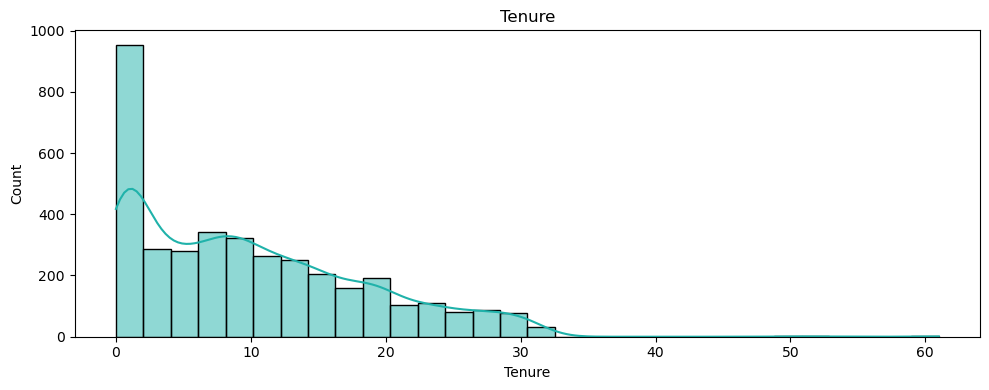

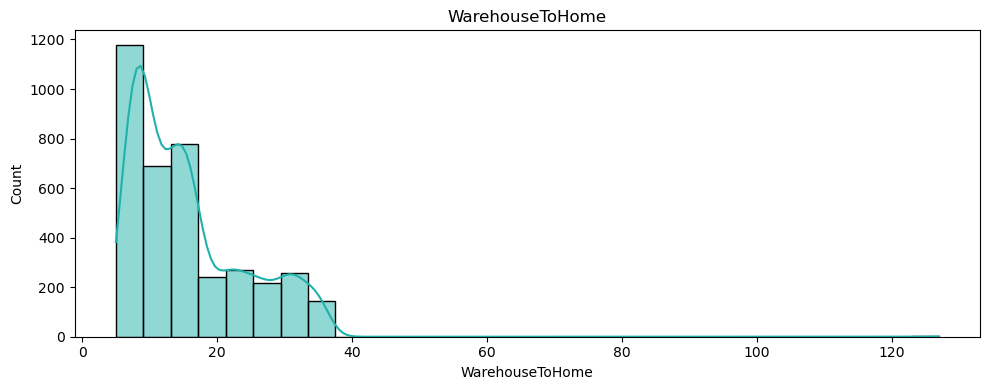

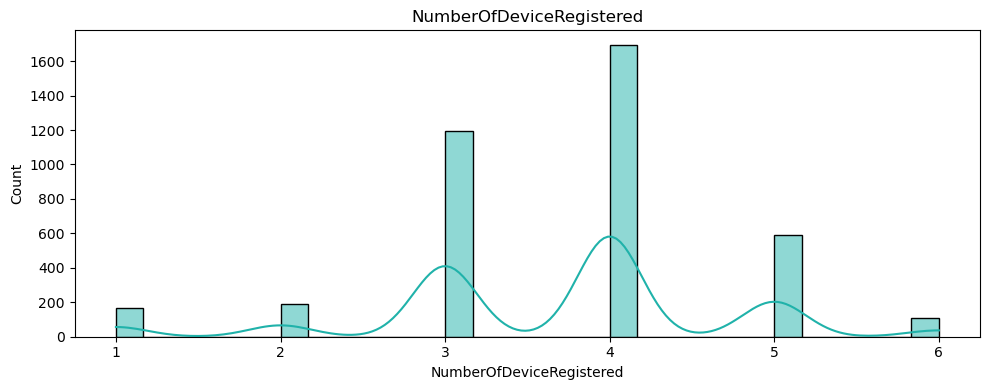

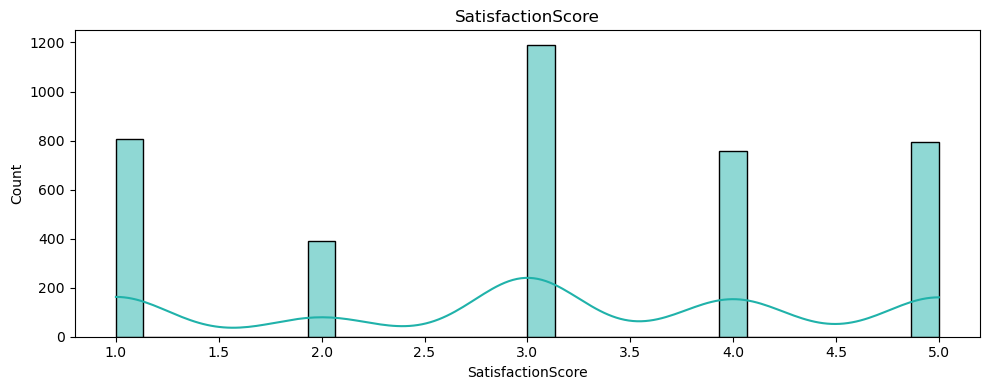

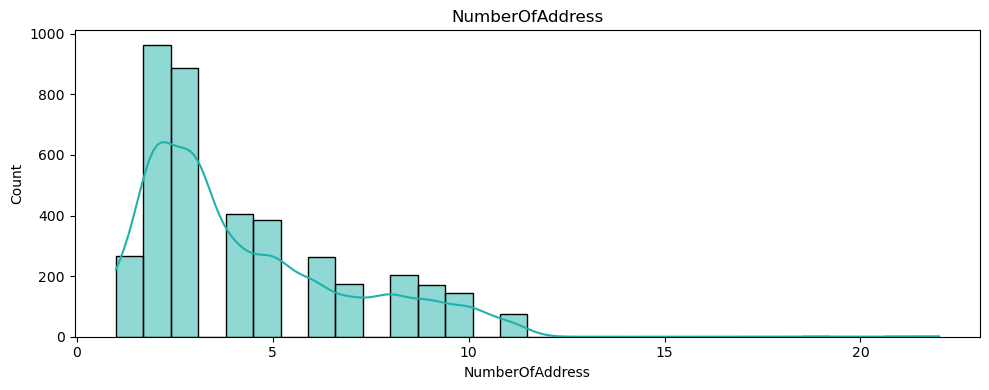

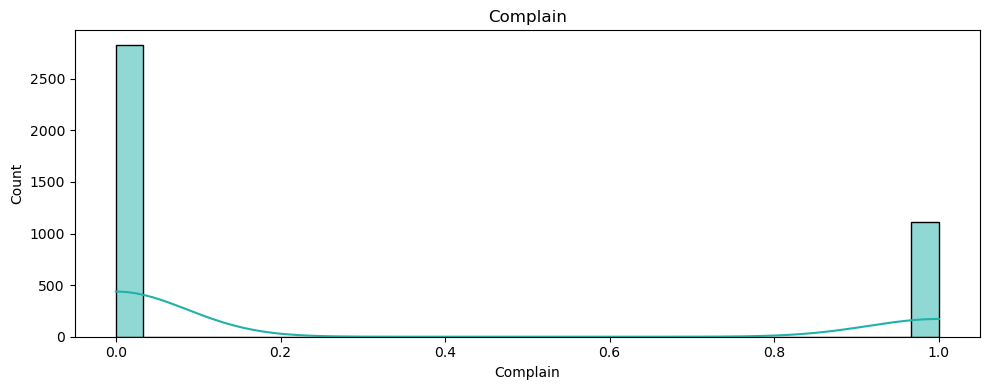

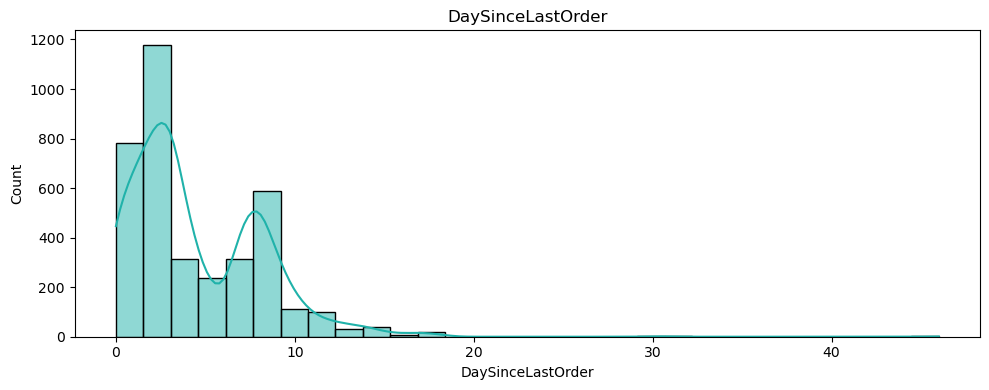

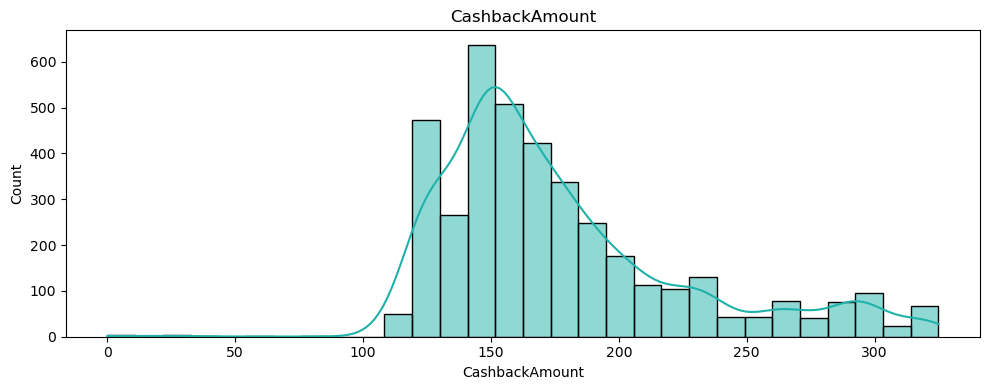

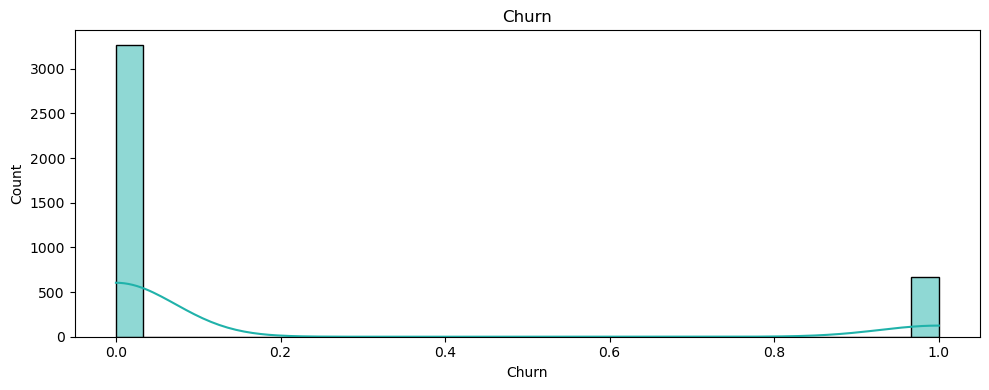

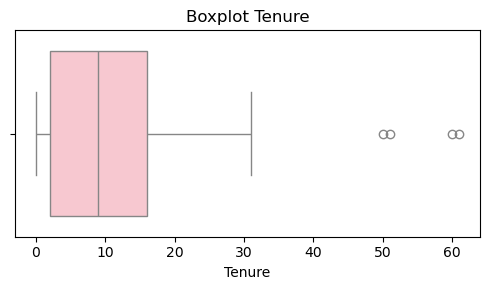

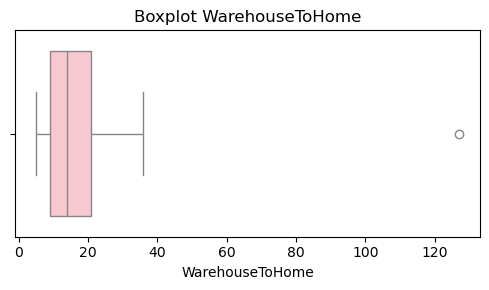

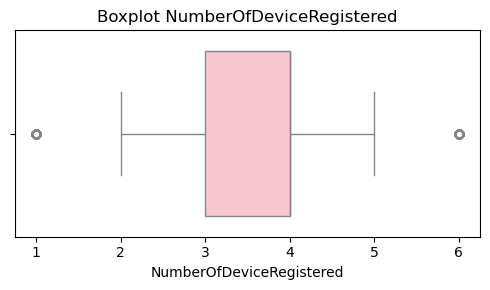

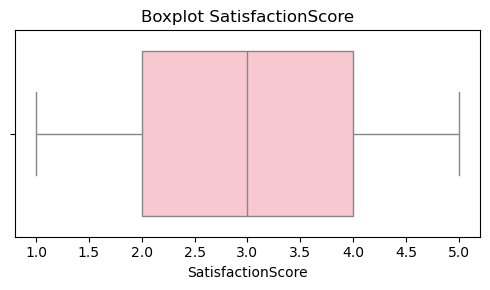

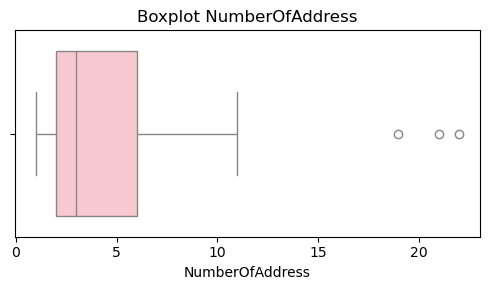

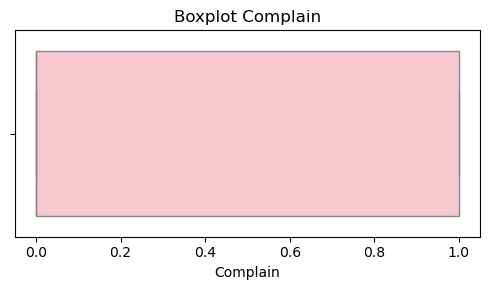

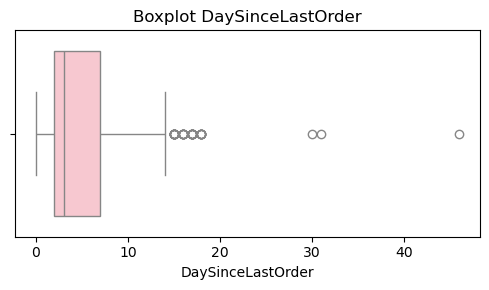

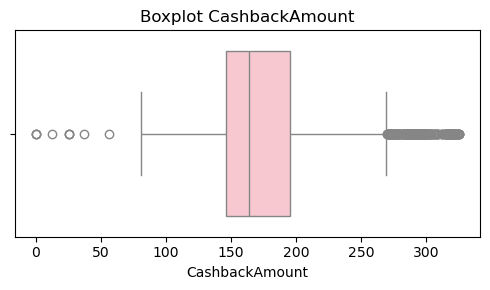

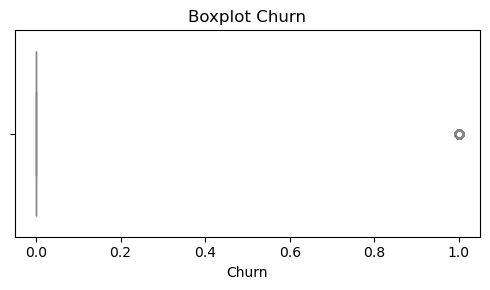

In [21]:
for column in df1.describe().columns : 
    plt.figure(figsize=(10,4))
    sns.histplot(df[column], bins=30, kde=True, color = '#20B2AA')
    plt.title(f'{column}')
    plt.tight_layout()
    plt.show()

for col in df1.describe().columns:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[col], color="pink")
    plt.title(f'Boxplot {col}')
    plt.tight_layout()
    plt.show()

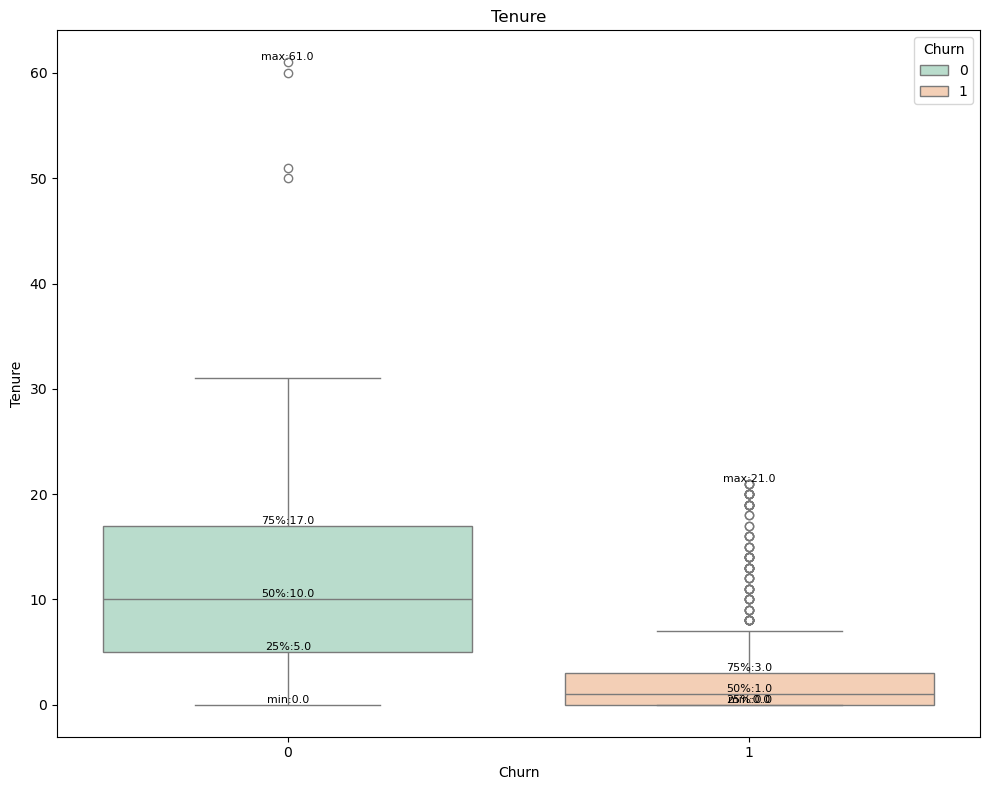

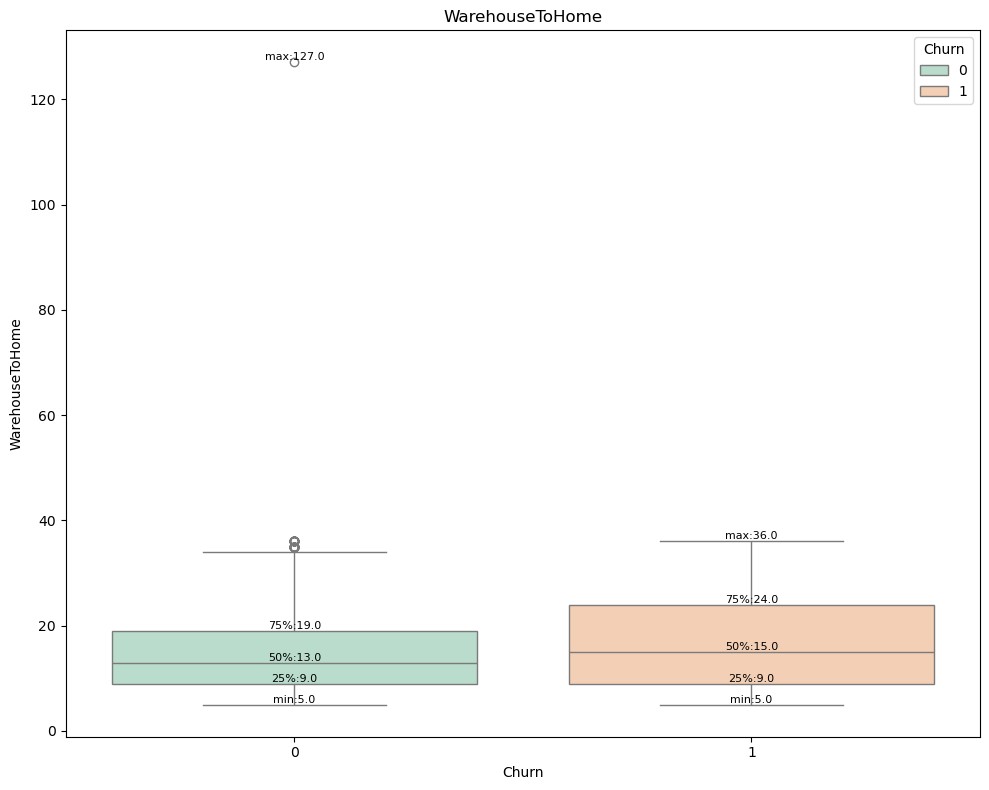

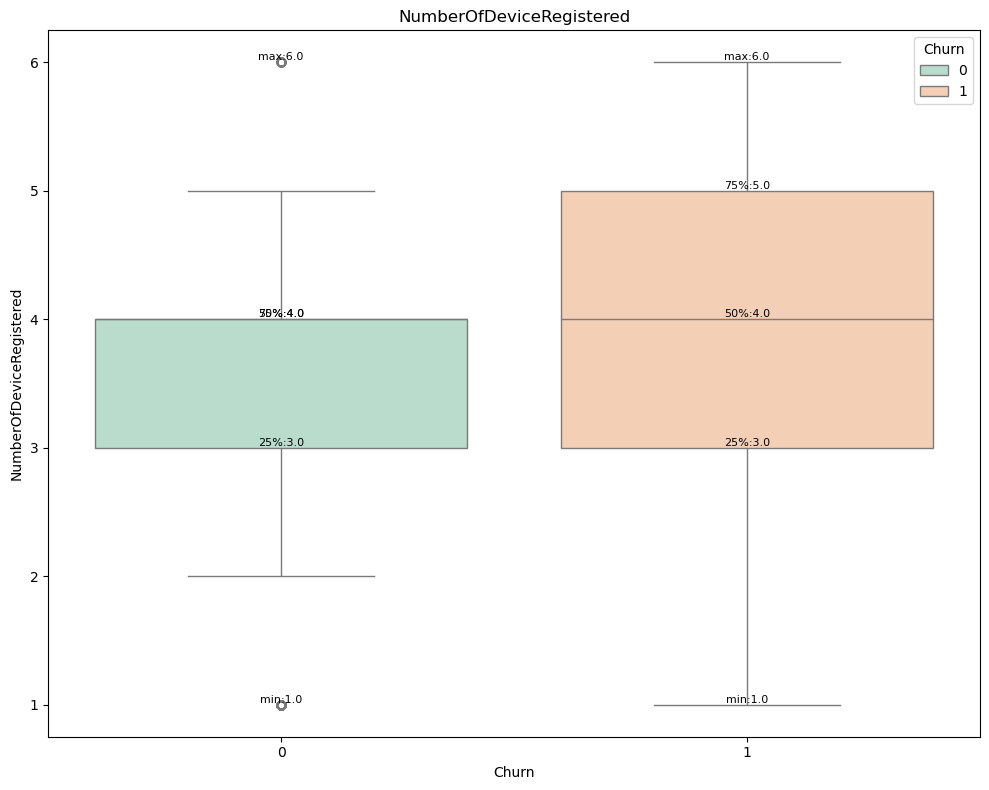

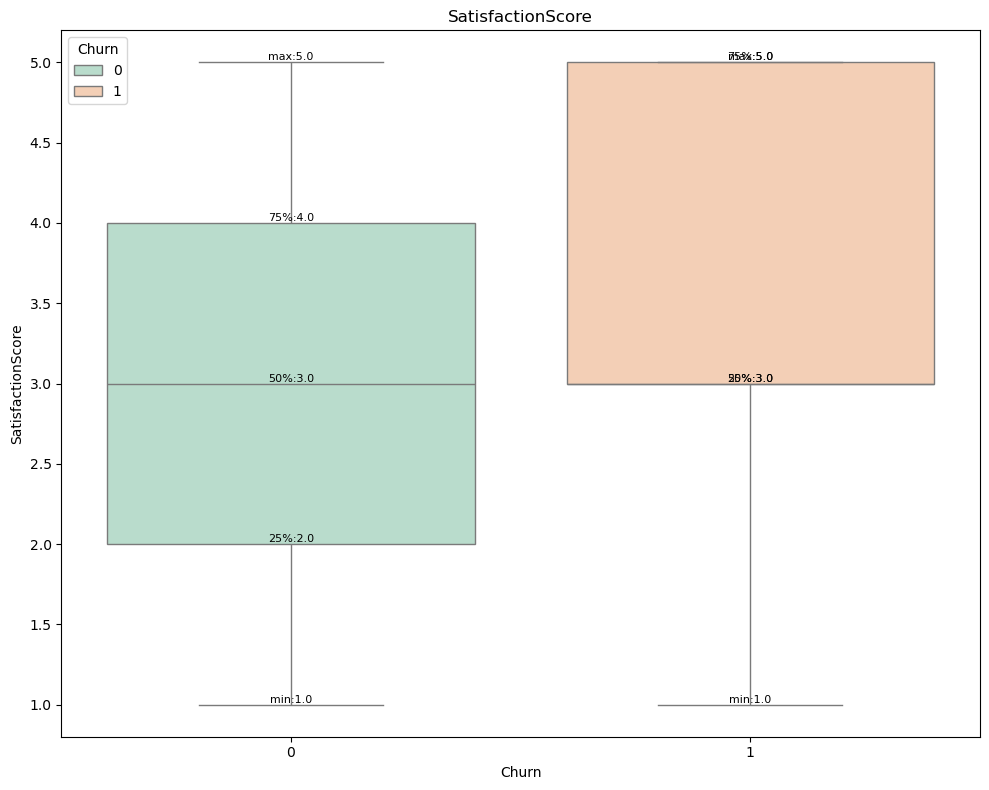

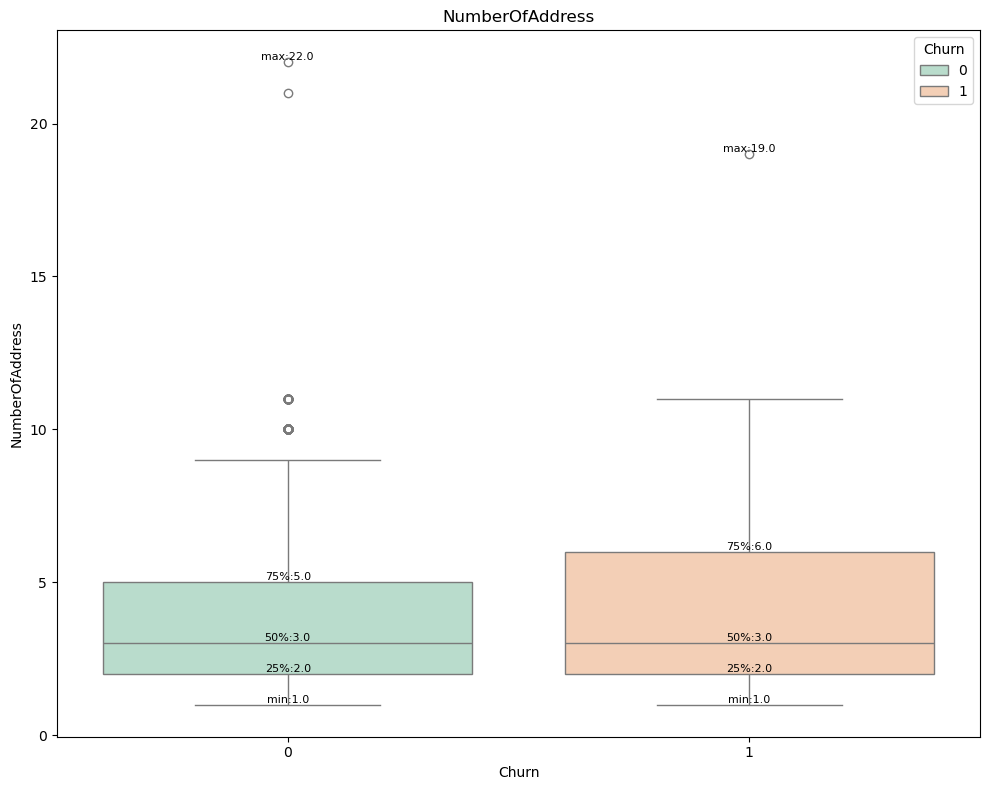

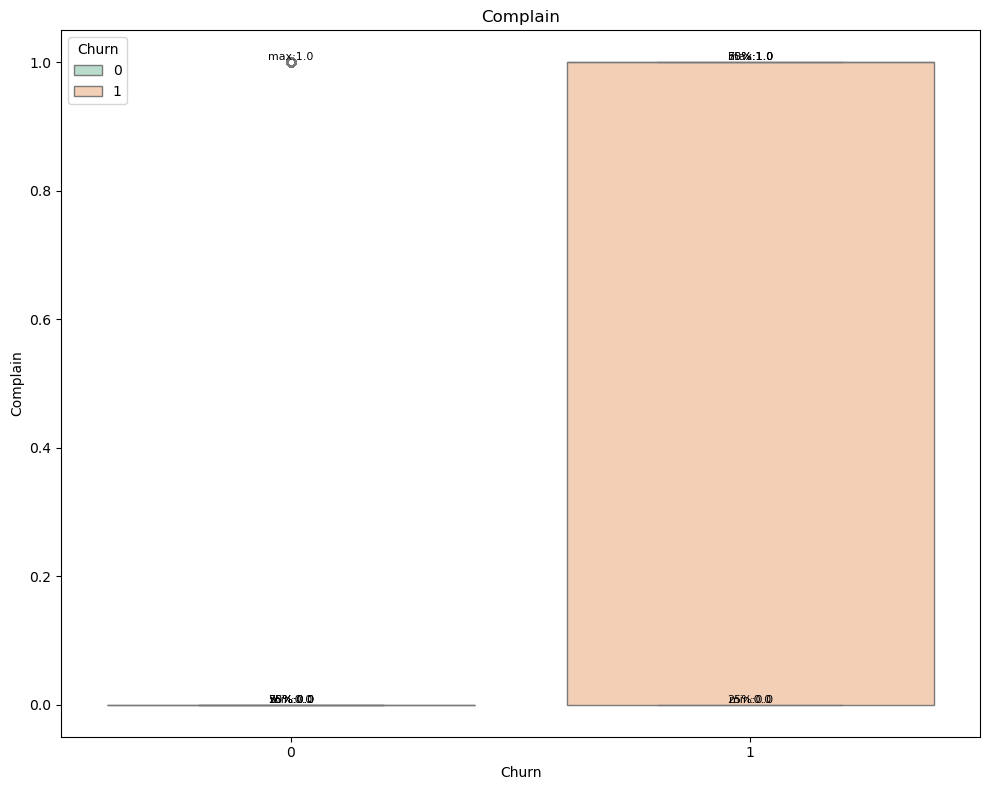

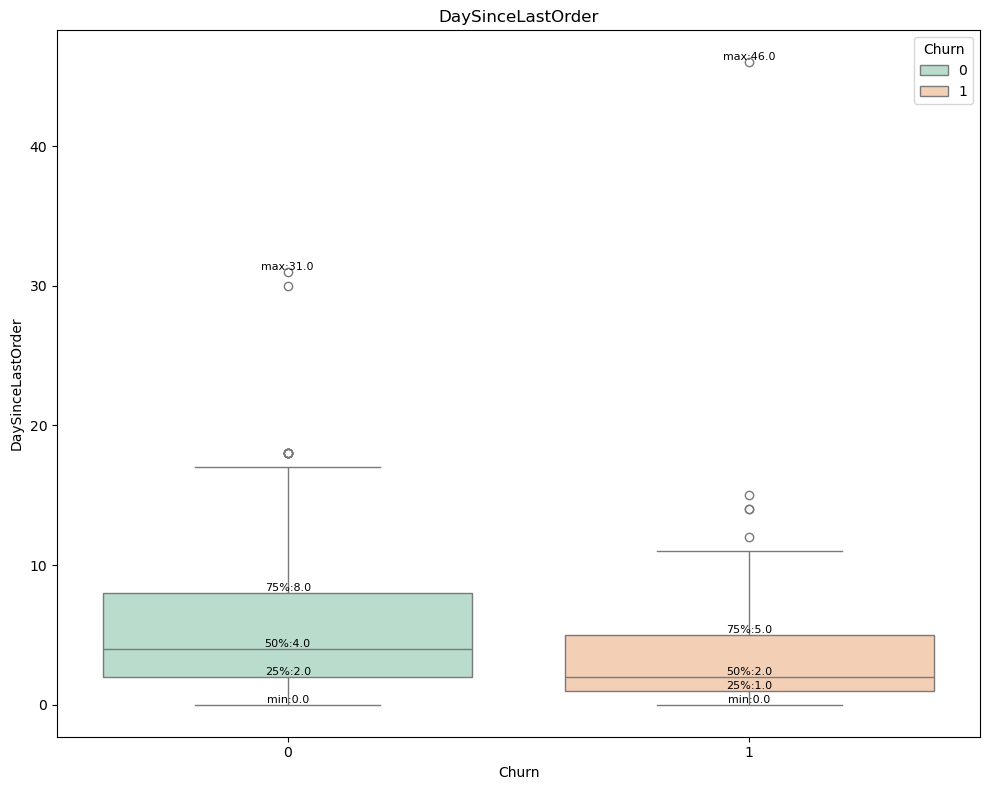

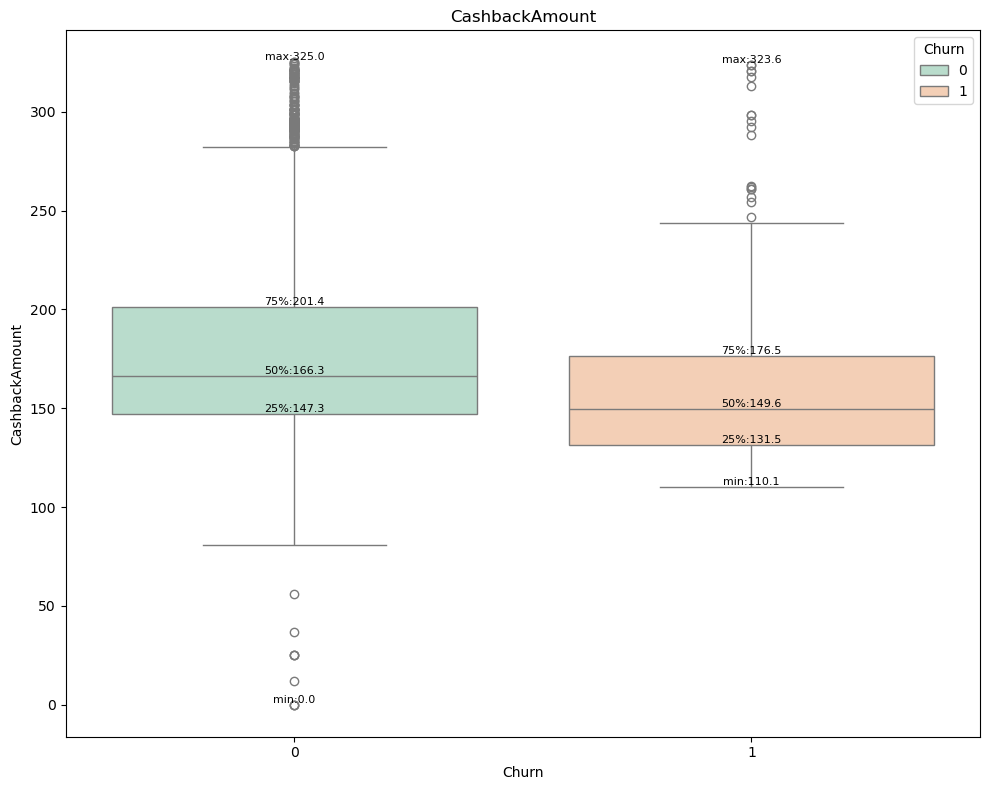

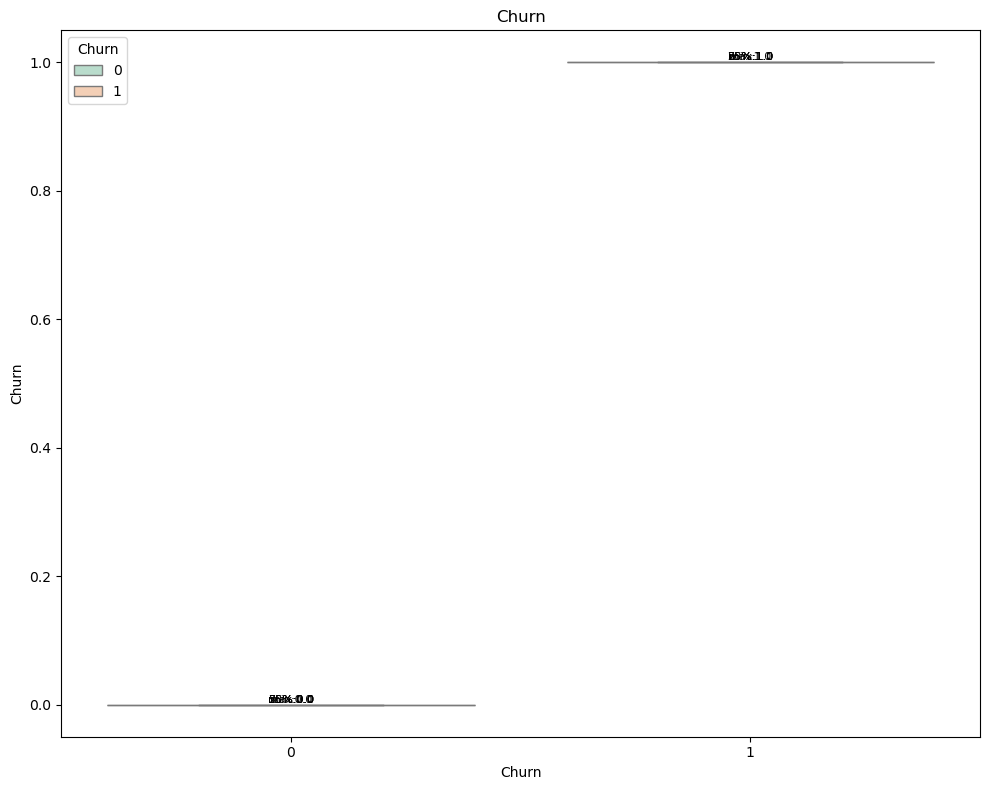

In [22]:
for column in df1.describe().columns:
    plt.figure(figsize=(10,8))
    ax = sns.boxplot(data=df1, x="Churn", y=column, hue="Churn", palette="Pastel2")

    # calculate group stats
    stats = df1.groupby("Churn")[column].describe()[["min","25%","50%","75%","max"]]

    # annotate values
    for i, (churn_value, row) in enumerate(stats.iterrows()):
        # x offset: each churn group has a position
        x_offset = i
        for stat_name, y_val in row.items():
            ax.text(
                x=x_offset, y=y_val,
                s=f"{stat_name}:{y_val:.1f}",
                ha="center", va="bottom",
                fontsize=8, color="black", rotation=0
            )

    plt.title(f'{column}')
    plt.tight_layout()
    plt.show()

Categorical Columns

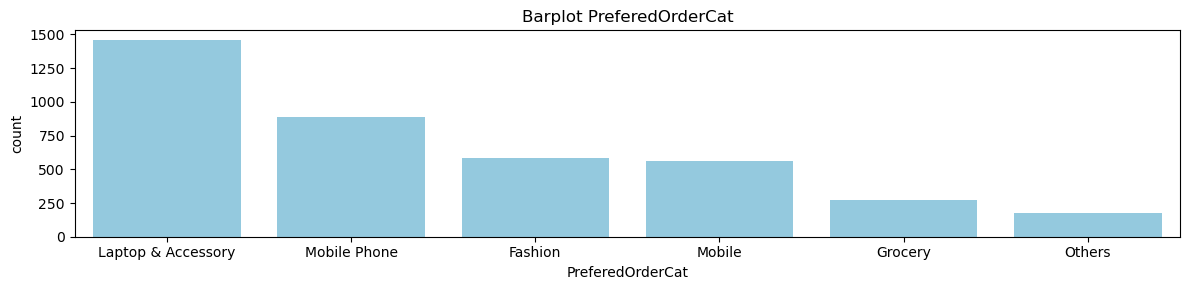

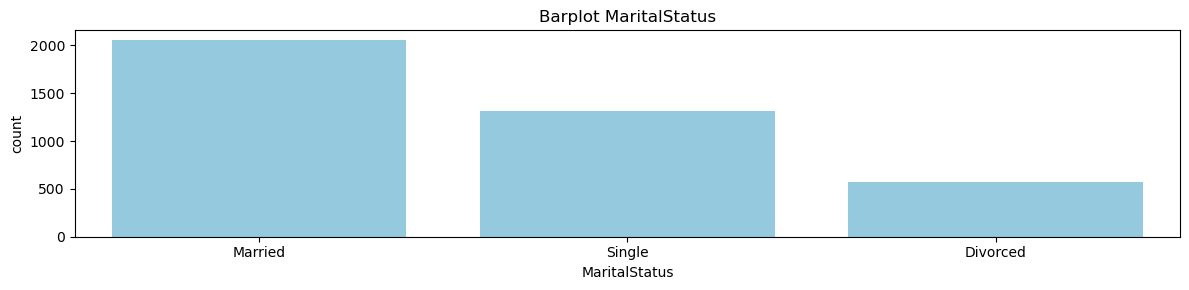

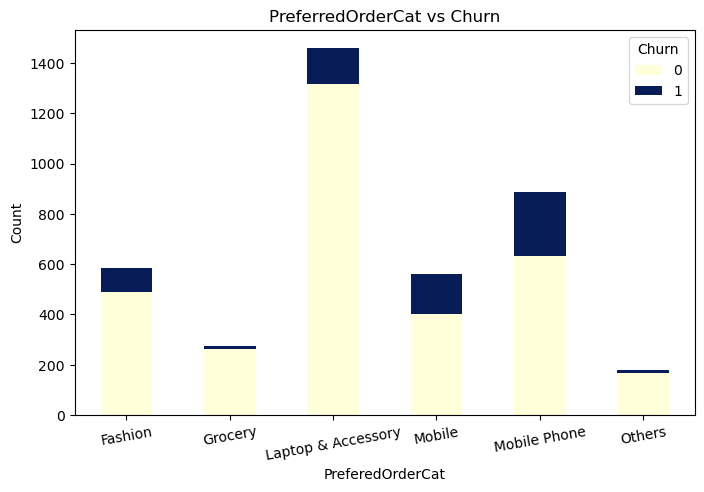

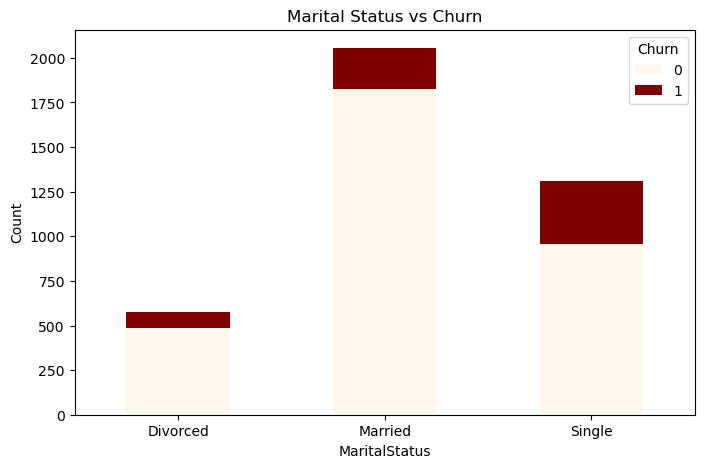

In [23]:
for col in df.describe(include = 'object'):
    plt.figure(figsize=(12,3))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, color = 'skyblue')
    plt.title(f'Barplot {col}')
    plt.xticks()
    plt.tight_layout()
    plt.show()

cross = pd.crosstab(df['PreferedOrderCat'], df['Churn'])
cross.plot(kind='bar', stacked=True, figsize=(8,5), colormap="YlGnBu")
plt.title("PreferredOrderCat vs Churn")
plt.ylabel("Count")
plt.xticks(rotation=10)
plt.show()

cross = pd.crosstab(df['MaritalStatus'], df['Churn'])
cross.plot(kind='bar', stacked=True, figsize=(8,5), colormap="OrRd")
plt.title("Marital Status vs Churn")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

Beberapa insight yang diperoleh:

1. The histogram of the Tenure column shows that a large number of customers leave the company within the first few months. This indicates a significant early churn problem, which we aim to address through predictive modeling and targeted retention strategies.
2. Terlihat tidak ada anomali nilai pada data sehingga tidak ada penghapusan outlier, melainkan akan discaling menggunakan robust scaling.
3. Kebanyakan churn ada dalam kategori elektronik (laptop & accesory, mobile, mobile phone)
4. Kita bisa lihat kalau perbandingan komplain dan churn mirip, sehingga ingin dilihat data pelanggan yang mempunyai komplain, nilai satisfaction scorenya bagaimnana dan apakah cashback amountnya bagaimana. Kemudian akan dibuat juga beberapa feature engineering yang sekiranya terlihat bisa memperlihatkan pola churn pada data

The Tenure histogram spikes in the first few months, signaling pronounced early churn that we’ll target with modeling and retention plays. We found no drop-worthy anomalies, so we’ll keep extremes and dampen their impact with robust scaling rather than deleting outliers. Churn is disproportionately concentrated in electronics (Laptop & Accessory, Mobile, Mobile Phone). Complaints closely track churn, so we’ll profile complainers by satisfaction and cashback to see which lever drives exits. And so to make the predictions more accurate, we'll add some feature engineering—e.g., complaint×satisfaction, complaint×cashback, and so on—to surface nonlinear signals and catch churn earlier.

We impute missing numeric values with the median because these features are skewed and heavy-tailed; the median is resistant to outliers, so it better reflects the “typical” customer than the mean (which would be dragged toward extreme values). We then apply robust scaling (center at the median, scale by the IQR) rather than standard or min–max scaling, so large but valid values don’t dominate the model. This puts features on a comparable scale for algorithms that care about magnitude and regularization

#### Pipeline 

In [24]:
df1.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn import set_config
from imblearn.over_sampling import SMOTE
set_config(transform_output="pandas")


In [26]:
class FeatureBuilder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_col='PreferedOrderCat'):
        self.cat_col = cat_col
        self.electronics_set = {
            'Mobile','Mobile Phone','Laptop & Accessory'
        }
    def fit(self, X, y=None): 
        return self
        
    def transform(self, X):
        X = X.copy()
        cat = X[self.cat_col].fillna('')

        X['is_electronics'] = cat.isin(self.electronics_set).astype(int)
        X['is_groceries']   = (cat == 'Grocery').astype(int)
        X['is_fashion']     = (cat == 'Fashion').astype(int)

        X['tenure_x_DaySinceLastOrder']        = X['Tenure'] * X['DaySinceLastOrder']
        X['complaint_x_satisfaction']= X['Complain'] * X['SatisfactionScore']
        X['complaint_x_cashback']    = X['Complain'] * X['CashbackAmount']
        X['tenure_x_devices']        = X['Tenure'] * X['NumberOfDeviceRegistered']
        X['tenure_x_addresses']      = X['Tenure'] * X['NumberOfAddress']
    
        X['is_electronics_x_DaySinceLastOrder']= X['is_electronics'] * X['DaySinceLastOrder']
        X['is_groceries_x_DaySinceLastOrder']  = X['is_groceries']   * X['DaySinceLastOrder']
        X['is_fashion_x_DaySinceLastOrder']    = X['is_fashion']     * X['DaySinceLastOrder']

        X['is_electronics_x_cashback']= X['is_electronics'] * X['CashbackAmount']
        X['is_groceries_x_cashback']  = X['is_groceries']   * X['CashbackAmount']
        X['is_fashion_x_cashback']    = X['is_fashion']     * X['CashbackAmount']

        X['is_groceries_x_distance']       = X['is_groceries']   * X['WarehouseToHome']
        X['is_fashion_x_distance']         = X['is_fashion']     * X['WarehouseToHome']
        X['is_electronics_x_distance']     = X['is_electronics'] * X['WarehouseToHome']

        X['is_groceries_x_complaint']= X['is_groceries']   * X['Complain']
        X['is_fashion_x_complaint']  = X['is_fashion']     * X['Complain']
        X['is_electronics_x_complaint']= X['is_electronics'] * X['Complain']
        return X

In [27]:
base_num_cols = [
    "Tenure","DaySinceLastOrder","CashbackAmount","WarehouseToHome",
    "NumberOfDeviceRegistered","NumberOfAddress","SatisfactionScore","Complain"
]

In [28]:
base_cat_cols = ["MaritalStatus"]

In [29]:
fe = [
    "is_electronics","is_groceries","is_fashion",
    "tenure_x_DaySinceLastOrder","complaint_x_satisfaction","complaint_x_cashback",
    "tenure_x_devices","tenure_x_addresses",
    "is_electronics_x_DaySinceLastOrder","is_groceries_x_DaySinceLastOrder","is_fashion_x_DaySinceLastOrder",
    "is_electronics_x_cashback","is_groceries_x_cashback","is_fashion_x_cashback",
    "is_groceries_x_distance","is_fashion_x_distance","is_electronics_x_distance",
    "is_groceries_x_complaint","is_fashion_x_complaint","is_electronics_x_complaint"
]

In [30]:
num_pipe = Pipeline([
    ("median", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

In [31]:
cat_pipe = Pipeline([
    ("mode", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))
])

In [32]:
ct = ColumnTransformer([
    ("num", num_pipe, base_num_cols + fe),
    ("cat", cat_pipe, base_cat_cols)
], remainder="drop")

#### Splitting X, y

In [33]:
X = df.drop(columns=[ "Churn"])
y = df["Churn"]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [35]:
!pip install lightgbm

In [36]:
!pip install catboost

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
from sklearn.model_selection import cross_val_score

In [40]:
tree_bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state = 42)
random_forest = RandomForestClassifier(random_state = 42)
xgb = XGBClassifier(random_state = 42)
lgbm = LGBMClassifier(random_state = 42, verbose = 0)
cat = CatBoostClassifier(random_state = 42, verbose = 0)
svm = SVC(probability=True, class_weight="balanced")
knn = KNeighborsClassifier(weights="distance")

In [41]:
models = {
    'treebag': tree_bagging,
    'rf': random_forest,
    'xgb': xgb,
    'lgbm': lgbm,
    'cat': cat,
    'svm': svm,
    'knn' : knn
}

### Modelling

In [42]:
from sklearn.metrics import make_scorer, fbeta_score

In [43]:
F2 = make_scorer(fbeta_score, beta=2, average = 'binary')

In [44]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [45]:
results = []
for name, model in models.items():
    pipe = ImbPipeline([
        ('feature_engineering', FeatureBuilder()),
        ('preprocess', ct),
        ('model', model)
    ])

    f2 = cross_val_score(pipe, X_train, y_train, cv=skf, scoring=F2)
    roc_auc = cross_val_score(pipe, X_train, y_train, cv=skf, scoring="roc_auc")
    rec = cross_val_score(pipe, X_train, y_train, cv=skf, scoring="recall")

    results.append({
         "Model": name,
         "F2": f2.mean(),
         "ROC-AUC" : roc_auc.mean(),
         "Recall" : rec.mean()
     })

In [46]:
df_result = pd.DataFrame(results).sort_values("F2", ascending = False)
df_result

,Model,F2,ROC-AUC,Recall
2,xgb,0.769007,0.954410,0.755071
3,lgbm,0.753445,0.952271,0.738387
1,rf,0.750682,0.948587,0.734666
0,treebag,0.708016,0.935772,0.684510
4,cat,0.696013,0.947665,0.673555
6,knn,0.637912,0.902392,0.610263
5,svm,0.636384,0.795502,0.805140


Terlihat kalau top 3 nilai F2 terbesar adalah model **XGBoost**, **LGBM**, dan **Random Forest**. Sehingga dipilih 3 model tersebut untuk dilanjutkan dalam menghandling imbalance data.

#### SMOTE

In [48]:
from imblearn.over_sampling import SMOTE

In [49]:
models2 = {
    'rf': random_forest,
    'xgb': xgb,
    'lgbm': lgbm
}

In [50]:
results = []
for name, model in models2.items():
    pipe = ImbPipeline([
        ('feature_engineering', FeatureBuilder()),
        ('preprocess', ct),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    f2 = cross_val_score(pipe, X_train, y_train, cv=skf, scoring=F2)
    roc_auc = cross_val_score(pipe, X_train, y_train, cv=skf, scoring="roc_auc")
    rec = cross_val_score(pipe, X_train, y_train, cv=skf, scoring="recall")


    results.append({
         "Model": name,
         "F2": f2.mean(),
         "ROC-AUC" : roc_auc.mean(),
         "Recall" : rec.mean()
     })

In [51]:
df_result = pd.DataFrame(results).sort_values("F2", ascending = False)
df_result

,Model,F2,ROC-AUC,Recall
0,rf,0.793335,0.952304,0.801436
1,xgb,0.790522,0.956206,0.786604
2,lgbm,0.766320,0.947595,0.762548


#### OverSampling

In [52]:
from imblearn.over_sampling import RandomOverSampler

In [54]:
results = []
for name, model in models2.items():
    pipe = ImbPipeline([
        ('feature_engineering', FeatureBuilder()),
        ('preprocess', ct),
        ("ros", RandomOverSampler(random_state=42)),
        ('model', model)
    ])

    f2 = cross_val_score(pipe, X_train, y_train, cv=skf, scoring=F2)
    roc_auc = cross_val_score(pipe, X_train, y_train, cv=skf, scoring="roc_auc")
    rec = cross_val_score(pipe, X_train, y_train, cv=skf, scoring="recall")


    results.append({
         "Model": name,
         "F2": f2.mean(),
         "ROC-AUC" : roc_auc.mean(),
         "Recall" : rec.mean()
     })

In [55]:
df_result = pd.DataFrame(results).sort_values("F2", ascending = False)
df_result

,Model,F2,ROC-AUC,Recall
1,xgb,0.814845,0.955133,0.820024
2,lgbm,0.810475,0.954533,0.823745
0,rf,0.803172,0.954299,0.803340


Terlihat kalau 3 model dengan menggunakan Oversampling memiliki nilai F2 lebih baik daripada menggunakan SMOTE. Sehingga dipilihlah Oversampling untuk lanjut ke tahapan berikutnya yaitu mengecek menggunakan data test.

### Check Best 3 Models in Test Set (XGBOOST, LGBM, RANDOM FOREST)  

In [56]:
random_forest = RandomForestClassifier(random_state = 42)
xgb = XGBClassifier(random_state = 42)
lgbm = LGBMClassifier(random_state = 42, verbose = 0)

In [57]:
models = {
    'rf': random_forest,
    'xgb': xgb,
    'lgbm': lgbm
}

In [58]:
from sklearn.metrics import fbeta_score, recall_score, roc_auc_score, make_scorer

In [60]:
results = []
for name, model in models.items():
    pipe = ImbPipeline([
        ('feature_engineering', FeatureBuilder()),
        ('preprocess', ct),
        ("ros", RandomOverSampler(random_state=42)),
        ('model', model)
    ])
    
    f2_val = cross_val_score(pipe, X_train, y_train, cv = skf, scoring = F2)
    rec_val = cross_val_score(pipe, X_train, y_train, cv = skf, scoring = "recall")
    rocauc_val = cross_val_score(pipe, X_train, y_train, cv = skf, scoring = "roc_auc")
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_pred_proba = pipe.predict_proba(X_test)[:,1]

    f2_test = fbeta_score(y_test, y_pred, beta=2)
    recall_test = recall_score(y_test, y_pred)
    roc_test    = roc_auc_score(y_test, y_pred_proba)
    
    results.append({
        "Model": name,
        "F2-Score Validation": f2_val.mean(),
        "Recall Validation":   rec_val.mean(),
        "ROC-AUC Validation":  rocauc_val.mean(),
        "F2-Score Test":       f2_test,
        "Recall Test":         recall_test,
        "ROC-AUC Test":        roc_test
    })

In [62]:
df_results = pd.DataFrame(results).sort_values("F2-Score Validation", ascending=False)
df_results

,Model,F2-Score Validation,Recall Validation,ROC-AUC Validation,F2-Score Test,Recall Test,ROC-AUC Test
1,xgb,0.814845,0.820024,0.955133,0.839580,0.829630,0.962419
2,lgbm,0.810475,0.823745,0.954533,0.822416,0.837037,0.958229
0,rf,0.803172,0.803340,0.954299,0.775602,0.762963,0.956988


Terlihat kalau model random forest terjadi overfitting. Sedangkan XGBoost dan LGBM tidak overfitting, malah mempunyai evaluasi yang lebih bagus untuk data test. Karena Xgboost terlihat yang memiliki nilai paling tinggi baik untuk validation maupun test, maka dipilih model tersebut untuk dilakukan tahap selanjutnya yaitu tuning

In [63]:
from sklearn.model_selection import RandomizedSearchCV

### Hyperparameter Tuning

In [64]:
pipe_tuned = ImbPipeline([
        ('feature_engineering', FeatureBuilder()),
        ('preprocess', ct),
        ("ros", RandomOverSampler(random_state=42)),
        ('model', XGBClassifier(random_state = 42))
    ])

In [65]:
param_grid = {
    'model__n_estimators': [200, 400, 600, 800, 1000],
    'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 4, 5, 6, 8, 10],
    'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__gamma': [0, 0.1, 0.5, 1, 5],
    'model__min_child_weight': [1, 3, 5, 7, 10],
    'model__scale_pos_weight' : [1, 2, 5, 10, 20, 50],
    'model__reg_alpha' : [0, 0.01, 0.1, 1, 5, 10],
    'model__reg_lambda' : [0, 0.01, 0.1, 1, 5, 10]
}

In [66]:
scoring = {
    'recall': 'recall',
    'f2': make_scorer(fbeta_score, beta=2),
    'roc_auc': 'roc_auc'
}

In [67]:
rand = RandomizedSearchCV(estimator = pipe_tuned,
                         param_distributions = param_grid,
                         n_iter = 50,
                         cv = skf,
                         n_jobs = -1,
                         random_state = 42,
                         scoring=scoring,
                         refit='f2'
                         )

rand.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('feature_engineering',
                                              FeatureBuilder()),
                                             ('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('median',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Tenure',
                                                                                'DaySinceLastOrder',
                                                                                'CashbackAmount',
                                                                                'WarehouseToHome...
                                                                    10],
                                        'model__n_estimators': [200, 400, 600,
                                                                800, 1000],
                                        'model__reg_alpha': [0, 0.01, 0.1, 1, 5,
                                                             10],
                                        'model__reg_lambda': [0, 0.01, 0.1, 1,
                                                              5, 10],
                                        'model__scale_pos_weight': [1, 2, 5, 10,
                                                                    20, 50],
                                        'model__subsample': [0.6, 0.7, 0.8, 0.9,
                                                             1.0]},
                   random_state=42, refit='f2',
                   scoring={'f2': make_scorer(fbeta_score, response_method='predict', beta=2),
                            'recall': 'recall', 'roc_auc': 'roc_auc'})

In [68]:
rand.best_params_

{'model__subsample': 0.9,
 'model__scale_pos_weight': 5,
 'model__reg_lambda': 5,
 'model__reg_alpha': 0.1,
 'model__n_estimators': 400,
 'model__min_child_weight': 5,
 'model__max_depth': 10,
 'model__learning_rate': 0.05,
 'model__gamma': 0,
 'model__colsample_bytree': 0.7}

In [69]:
rand.best_score_

np.float64(0.8303028290946207)

In [70]:
best_pipe_tuned = rand.best_estimator_
y_pred_tuned = best_pipe_tuned.predict(X_test)

In [71]:
f2_xgb_tuned = fbeta_score(y_test, y_pred_tuned, beta=2)
f2_xgb_tuned

0.8156028368794326

In [78]:
y_proba_tuned = best_pipe_tuned.predict_proba(X_test)[:,1]

In [79]:
recall_xgb_tuned = recall_score(y_test, y_pred_tuned)
roc_auc_xgb_tuned= roc_auc_score(y_test, y_proba_tuned)

In [80]:
recall_xgb_tuned

0.8518518518518519

In [81]:
roc_auc_xgb_tuned

np.float64(0.955363008268207)

Didapati nilai sebelumnya : 

1. **Recall** : 0.829630
2. **F2** : 0.839580
3. **ROC-AUC** : 0.962419

Setelah Hyperparameter Tuning : 
1. **Recall** : 0.85185185
2. **F2** : 0.8156028
3. **ROC-AUC** : 0.955363

Selanjutnya akan diturunkan threshold untuk menaikkan recall dan F2

#### Hyperparameter Tuning + Threshold

In [82]:
y_pred_proba = rand.predict_proba(X_test)[:, 1]

In [83]:
from sklearn.metrics import fbeta_score, recall_score, roc_auc_score

In [84]:
thresholds = np.arange(0.1, 0.91, 0.05)
results = []

for thr in thresholds:
    y_pred_thr = (y_pred_proba >= thr).astype(int)
    rec = recall_score(y_test, y_pred_thr)
    f2 = fbeta_score(y_test, y_pred_thr, beta=2)
    roc = roc_auc_score(y_test, y_pred_proba)

    results.append({
        "Threshold": thr,
        "Recall": rec,
        "F2": f2,
        "ROC AUC": roc
    })

In [85]:
df_thr = pd.DataFrame(results)
df_thr

,Threshold,Recall,F2,ROC AUC
0,0.10,0.940741,0.799748,0.955363
1,0.15,0.940741,0.817246,0.955363
2,0.20,0.933333,0.832232,0.955363
3,0.25,0.925926,0.843455,0.955363
4,0.30,0.896296,0.828767,0.955363
5,0.35,0.888889,0.832178,0.955363
6,0.40,0.881481,0.833333,0.955363
7,0.45,0.866667,0.821629,0.955363
8,0.50,0.851852,0.815603,0.955363
9,0.55,0.844444,0.816619,0.955363


**Best Threshold** : 0.25

Kesimpulan : 
1. Model terbaik adalah XGBoost dengan Robust Scaling, OverSampling, Hyperparameter Tuning dengan Threshold 0.25
2. Recall = 0.93 (92.6%) → model berhasil menemukan hampir semua churner, artinya sedikit sekali churner yang “lolos”. Ini penting karena cost kehilangan churner biasanya lebih besar daripada salah kasih promo.
3. F2 = 0.84 → skor ini menyeimbangkan precision & recall, tapi memberi bobot lebih besar ke recall. Nilai 0.84 cukup tinggi, artinya model efektif dalam menekan false negative (tidak melewatkan churner).
4. ROC AUC = 0.955 → sangat tinggi, menunjukkan model punya kemampuan kuat dalam membedakan churner vs non-churner

In [86]:
import pickle

In [87]:
final_model = rand.best_estimator_


In [89]:
with open("final_xgb_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

print("Final model saved as final_xgb_model.pkl")

Final model saved as final_xgb_model.pkl


In [90]:
xgb_model = final_model.named_steps["model"]

feature_names = final_model.named_steps["preprocess"].get_feature_names_out()

importances = xgb_model.feature_importances_

fitur_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)


In [91]:
fitur_importance

,Feature,Importance
0,num__Tenure,0.147703
17,num__is_groceries_x_DaySinceLastOrder,0.114464
12,num__complaint_x_satisfaction,0.084674
8,num__is_electronics,0.068304
14,num__tenure_x_devices,0.042164
20,num__is_groceries_x_cashback,0.036667
9,num__is_groceries,0.032936
22,num__is_groceries_x_distance,0.032038
11,num__tenure_x_DaySinceLastOrder,0.031019
7,num__Complain,0.030737


Berikut rekomendasi bisnis berdasarkan fitur paling berpengaruh:

1. Mitigasi churn dini (Tenure).
Berikan promo atau program lainnya di antara 1-3 bulan pertama.

2. Pemicu recency per kategori (Groceries × DaysSinceLastOrder).
Untuk groceries yang siklus belinya pendek, kirim seperti promo atau diskon

3. Jalur cepat pemulihan layanan (Complaint × Satisfaction).
Jika ada komplain dan skor kepuasan rendah, segera berikan penanggulangan, dan pantau penyelesaian hingga tuntas. Kelompok ini berisiko churn tinggi.

4. Insentif yang terarah (Groceries × Cashback).
Terapkan cashback lebih kuat pada pelanggan groceries yang mulai menurun transaksinya. 

5. Risiko kategori: Electronics flag.
Karena kategori electronics terlihat cukup signifikan utk churn, berikan penawaran spesifik kategori tersebut.